# Clusteranalyse

Schritte zur Vorbereitung, später evtl. schon im Preprossessing erledigt:

Format
- Datumsspalte in Jahr, Monat, Tag trennen

Daten entfernen
- **Zeilen** aus 2014 und 2025 entfernen, weil zu wenige Datenpunkte
- **Spalten** mit zu vielen fehlenden Werten entfernen (cut-off: 53% missing values)
- Alle Einträge für **Tehran** entfernen, weil die Stadt durch ihre extrem hohen Schadstoffwerte die Clusteranalyse verzerrt

Aktuell auch noch relevant, aber im großen Datensatz vielleicht nicht mehr
- Bestimmen, in welchen der 95 Städte für **alle Schadstoffe** Messwerte vorliegen --> 54 Städte

Clusteranalyse
- StandardScaler und KMeans importieren
- Liste der Schadstoffe definieren (pollutants)
- gruppierten ("City") und reduzierten ("dropna") mit Mittelwerten ("mean") df nach Städten und Schadstoffen für als Datengrundlage der Clusteranalyse erstellen (**df_cluster**). df-cluster hat 53 Zeilen (Städte) und 6 Spalten (Schadstoffe)
- Daten skalieren (**df_cluster_scaled**)
- mit Ellbow-Methode optimale Clusteranzahl bestimmen --> 5 Cluster (Silhouette wurde auch getestet, brachte keinen Mehrwert)
- mit Kmeans Clusterzuordnung durchführen (**df_cluster_numbers**)

In [1]:
# imports
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [2]:
# Settings for displaying floats
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
df = pd.read_csv("/Users/mareikekeller/air_quality/data/cleaned_data.csv")
df.head()

,Date,Country,City,aqi,co,d,dew,humidity,mepaqi,no2,...,pol,precipitation,pressure,psi,so2,temperature,uvi,wd,wind-gust,wind-speed
0,2014-12-29,AT,Vienna,NaN,0.10,NaN,NaN,NaN,NaN,9.00,...,NaN,NaN,NaN,NaN,2.60,NaN,NaN,NaN,NaN,NaN
1,2014-12-29,AU,Brisbane,NaN,1.90,NaN,NaN,NaN,NaN,4.60,...,NaN,NaN,NaN,NaN,1.10,NaN,NaN,NaN,NaN,NaN
2,2014-12-29,BE,Brussels,NaN,0.10,NaN,NaN,NaN,NaN,23.40,...,NaN,NaN,NaN,NaN,1.60,NaN,NaN,NaN,NaN,NaN
3,2014-12-29,BO,Cochabamba,NaN,NaN,NaN,NaN,NaN,NaN,3.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-12-29,BR,São Paulo,NaN,5.50,NaN,NaN,NaN,NaN,17.90,...,NaN,NaN,NaN,NaN,1.10,NaN,NaN,NaN,NaN,NaN


In [4]:
# Data preparation: Manipulating the 'Date' column

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Split 'Date' column into 'year', 'month' and 'day'
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

# Remove 'Date' column
if 'Date' in df.columns:
    df.drop(columns=['Date'], inplace=True)

In [5]:
# Daten für 2014 & 2025 entfernen, weil zu wenige Datenpunkte

df = df[(df["year"] > 2014) & (df["year"] < 2025)]

In [6]:
# Tehran komplett entfernen, weil die Schadstoffwerte zu sehr von allen übrigen Städten abweichen
df = df[df["City"] != "Tehran"]

In [7]:
print("Tehran noch im DataFrame?", "Tehran" in df["City"].values)

Tehran noch im DataFrame? False


In [8]:
df['City'].nunique()

94

In [9]:
# Display the first 5 rows of the dataframe
df.head()

,Country,City,aqi,co,d,dew,humidity,mepaqi,no2,o3,...,psi,so2,temperature,uvi,wd,wind-gust,wind-speed,year,month,day
139,AT,Vienna,NaN,0.10,NaN,NaN,NaN,NaN,7.80,NaN,...,NaN,2.60,NaN,NaN,NaN,NaN,NaN,2015,1,1
140,AU,Brisbane,NaN,1.90,NaN,NaN,NaN,NaN,1.90,4.90,...,NaN,1.10,NaN,NaN,NaN,NaN,NaN,2015,1,1
141,BE,Brussels,NaN,0.10,NaN,NaN,NaN,NaN,12.40,16.30,...,NaN,1.60,NaN,NaN,NaN,NaN,NaN,2015,1,1
142,BO,Cochabamba,NaN,NaN,NaN,NaN,NaN,NaN,4.30,10.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,1,1
143,BR,São Paulo,NaN,4.60,NaN,NaN,NaN,NaN,7.40,19.50,...,NaN,1.10,NaN,NaN,NaN,NaN,NaN,2015,1,1


In [10]:
df.shape

(218703, 26)

In [7]:
# Spalten mit zu vielen fehlenden Werten entfernen

# Berechnen, wie viele Prozent der Werte pro Spalte fehlen
missing_percent = df.isna().mean() * 100  

# Spalten auswählen, die weniger als 50% fehlende Werte haben
df_cleaned = df.loc[:, missing_percent <= 53]

# Ergebnis ausgeben
print(f"Anzahl der entfernten Spalten: {df.shape[1] - df_cleaned.shape[1]}")
print("Übrige Spalten:", df_cleaned.columns)


Anzahl der entfernten Spalten: 9
Übrige Spalten: Index(['Country', 'City', 'co', 'dew', 'humidity', 'no2', 'o3', 'pm10', 'pm25',
       'pressure', 'so2', 'temperature', 'wind-gust', 'wind-speed', 'year',
       'month', 'day'],
      dtype='object')


In [8]:
df_cleaned["City"].nunique()

94

In [12]:
# # Mit Heatmap herausfinden, welche Städte für welche Schadstoffe fehlende Werte haben

# # Liste der Schadstoff-Features für das Clustering
# pollutants = ["co", "no2", "o3", "so2", "pm10", "pm25"]

# # DataFrame mit den Schadstoffen pro Stadt erstellen
# df_missing = df_cleaned.groupby("City")[pollutants].mean()

# # Boolean-Maske für fehlende Werte erstellen (True = fehlend, False = vorhanden)
# missing_data = df_missing.isna()

# # Größe der Grafik anpassen
# plt.figure(figsize=(8, 20))

# # Heatmap zeichnen (dunklere Farben = mehr fehlende Werte)
# sns.heatmap(missing_data, cmap="coolwarm", cbar=False, linewidths=0.5)

# # Achsentitel setzen
# plt.xlabel("Schadstoffe")
# plt.ylabel("Städte")
# plt.title("Heatmap der fehlenden Werte pro Stadt und Schadstoff")


In [ ]:
# missing_per_city = df_missing.isna().sum(axis=1)
# missing_per_city_sorted = missing_per_city.sort_values(ascending=False)
# print(missing_per_city_sorted.to_string())


## Code für Clusteranalyse (K-Means) zur Schadstoffbelastung

In [10]:
# Clusteranalyse zur Schadstoffbelastung

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Liste der Schadstoff-Features für das Clustering
pollutants = ["co", "no2", "o3", "so2", "pm10", "pm25"]

# Durchschnittliche Schadstoffwerte pro Stadt berechnen
df_cluster = df_cleaned.groupby("City")[pollutants].mean().dropna()



In [14]:
df_cluster.head()

,co,no2,o3,so2,pm10,pm25
City,,,,,,
Abu Dhabi,0.10,12.10,27.64,4.96,80.03,98.72
Amsterdam,2.86,10.22,19.80,0.40,15.90,39.81
Ankara,9.02,20.80,13.28,4.07,37.77,59.94
Athens,0.10,11.67,29.59,3.64,24.26,52.64
Belgrade,4.72,11.50,17.01,6.03,24.60,62.22


In [15]:
df_cluster.shape

(53, 6)

In [11]:
# Daten skalieren (K-Means ist empfindlich gegenüber unterschiedlichen Skalen)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Ergebnis als DataFrame zurückgeben
df_cluster_scaled = pd.DataFrame(df_scaled, index=df_cluster.index, columns=pollutants)

# Überprüfen, ob die Daten korrekt vorbereitet sind
df_cluster_scaled.head()

,co,no2,o3,so2,pm10,pm25
City,,,,,,
Abu Dhabi,-1.16,0.36,1.41,0.46,2.34,1.41
Amsterdam,-0.39,-0.04,0.34,-0.96,-0.69,-0.73
Ankara,1.33,2.21,-0.55,0.18,0.34,-0.00
Athens,-1.16,0.27,1.68,0.05,-0.30,-0.27
Belgrade,0.13,0.23,-0.04,0.80,-0.28,0.08


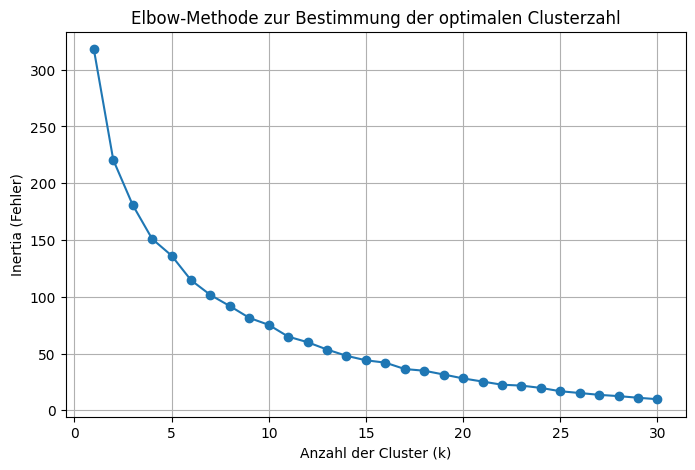

In [17]:
# Teste verschiedene Clusterzahlen (k = 1 bis 10)
inertia = []
k_values = range(1, 31)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)  # Speichert den Fehler (Inertia)

# Elbow-Plot erstellen
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel("Anzahl der Cluster (k)")
plt.ylabel("Inertia (Fehler)")
plt.title("Elbow-Methode zur Bestimmung der optimalen Clusterzahl")
plt.grid(True);

In [12]:
# K-Means-Clustering
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
df_cluster_scaled["Cluster"] = kmeans.fit_predict(df_cluster_scaled)

# Neue Cluster-Zuordnung der Städte anzeigen
df_cluster_numbers = df_cluster_scaled[["Cluster"]].sort_values(by="Cluster")
df_cluster_numbers

,Cluster
City,
London,0
Marseille,0
Łódź,0
Nicosia,0
Oslo,0
Hamburg,0
Fresno,0
Tokyo,0
Copenhagen,0


In [ ]:
# # Delhi wird bei 5 und 6 Clustern von KMeans als eigenes Cluster isoliert.
# # Test, ob DBSCAN eine andere Clusterbildung erzielt

# from sklearn.cluster import DBSCAN

# dbscan = DBSCAN(eps=3.5, min_samples=4)  # Parameter ggf. anpassen
# df_cluster["Cluster_DBSCAN"] = dbscan.fit_predict(df_scaled)

In [ ]:
# df_cluster["Cluster_DBSCAN"].value_counts()


Cluster_DBSCAN
 0    52
-1     1
Name: count, dtype: int64

In [ ]:
# df_cluster[df_cluster.index == "Delhi"]

,co,no2,o3,so2,pm10,pm25,Cluster_DBSCAN
City,,,,,,,
Delhi,9.33,16.32,9.24,5.46,130.19,163.57,-1


Entscheidung: Tehran war schon rausgenommen, weil es ein eigenes Cluster bildet. Ohne Tehran bildet Delhi ein eigenes Cluster. Das lassen wir jetzt erst mal so.

## Zusammenführung Geodaten und Clusternummern

In [ ]:
# import os
# print(os.getcwd())

/Users/mareikekeller/air_quality/WORK


In [13]:
df_geodata = pd.read_csv("df_geodata.csv")
df_geodata.head() 

,City,Latitude,Longitude
0,vienna,48.21,16.37
1,brisbane,-27.47,153.03
2,brussels,50.85,4.35
3,cochabamba,-17.39,-66.16
4,são paulo,-23.55,-46.64


In [42]:
df_cluster_numbers.head(20)

,Cluster
City,
london,0
marseille,0
łódź,0
nicosia,0
oslo,0
hamburg,0
fresno,0
tokyo,0
copenhagen,0


In [43]:
print(df_cluster_numbers)

              Cluster
City                 
london              0
marseille           0
łódź                0
nicosia             0
oslo                0
hamburg             0
fresno              0
tokyo               0
copenhagen          0
rijeka              0
taipei              0
rome                0
budapest            0
brussels            0
tel aviv            0
bilbao              0
athens              0
amsterdam           0
manila              0
reykjavík           1
singapore           1
skopje              1
sofia               1
saint-denis         1
tashkent            1
calama              1
bogotá              1
brisbane            1
buenos aires        1
dammam              1
chiang mai          1
vereeniging         1
vancouver           1
delhi               2
quito               3
ankara              3
macau               3
hong kong           3
moscow              3
seoul               3
tbilisi             3
belgrade            3
são paulo           3
ulan bator

In [38]:
print(df_cluster_numbers.index[:10])  # Zeigt die ersten 10 Indexwerte von df_cluster_numbers
print(df_geodata["City"].unique()[:10])

Index(['London', 'Marseille', 'Łódź', 'Nicosia', 'Oslo', 'Hamburg', 'Fresno',
       'Tokyo', 'Copenhagen', 'Rijeka'],
      dtype='object', name='City')
['vienna' 'brisbane' 'brussels' 'cochabamba' 'são paulo' 'london'
 'vancouver' 'zürich' 'calama' 'shijiazhuang']


In [15]:
df_geodata["City"] = df_geodata["City"].str.strip().str.lower()
df_cluster_numbers.index = df_cluster_numbers.index.str.strip().str.lower()

In [16]:
df_geodata = df_geodata.merge(df_cluster_numbers[["Cluster"]], left_on="City", right_index=True, how="left")


In [17]:
df_geodata.head()

,City,Latitude,Longitude,Cluster
0,vienna,48.21,16.37,NaN
1,brisbane,-27.47,153.03,1.00
2,brussels,50.85,4.35,0.00
3,cochabamba,-17.39,-66.16,NaN
4,são paulo,-23.55,-46.64,3.00


In [ ]:
df_geodata = df_geodata.dropna(subset=["Cluster"])

In [19]:
df_geodata

,City,Latitude,Longitude,Cluster
1,brisbane,-27.47,153.03,1.00
2,brussels,50.85,4.35,0.00
4,são paulo,-23.55,-46.64,3.00
5,london,51.51,-0.13,0.00
6,london,42.98,-81.23,0.00
7,vancouver,49.25,-123.12,1.00
9,calama,-22.46,-68.92,1.00
10,shijiazhuang,38.04,114.48,4.00
11,bogotá,4.61,-74.08,1.00
12,nicosia,35.18,33.36,0.00


## Cluster farbig plotten

In [21]:


import geodatasets
import matplotlib.pyplot as plt

# Weltkarte laden
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Städte aus df_geodata in einen GeoDataFrame umwandeln
gdf_cities = gpd.GeoDataFrame(df_geodata, 
                              geometry=gpd.points_from_xy(df_geodata["Longitude"], df_geodata["Latitude"]))


In [35]:
import matplotlib.colors as mcolors

# Eigene 5-Farben-Palette aus 'tab10' extrahieren
custom_cmap = mcolors.ListedColormap(plt.get_cmap("tab10").colors[:5])

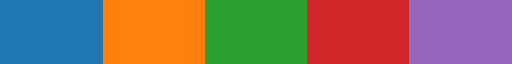

In [36]:
custom_cmap

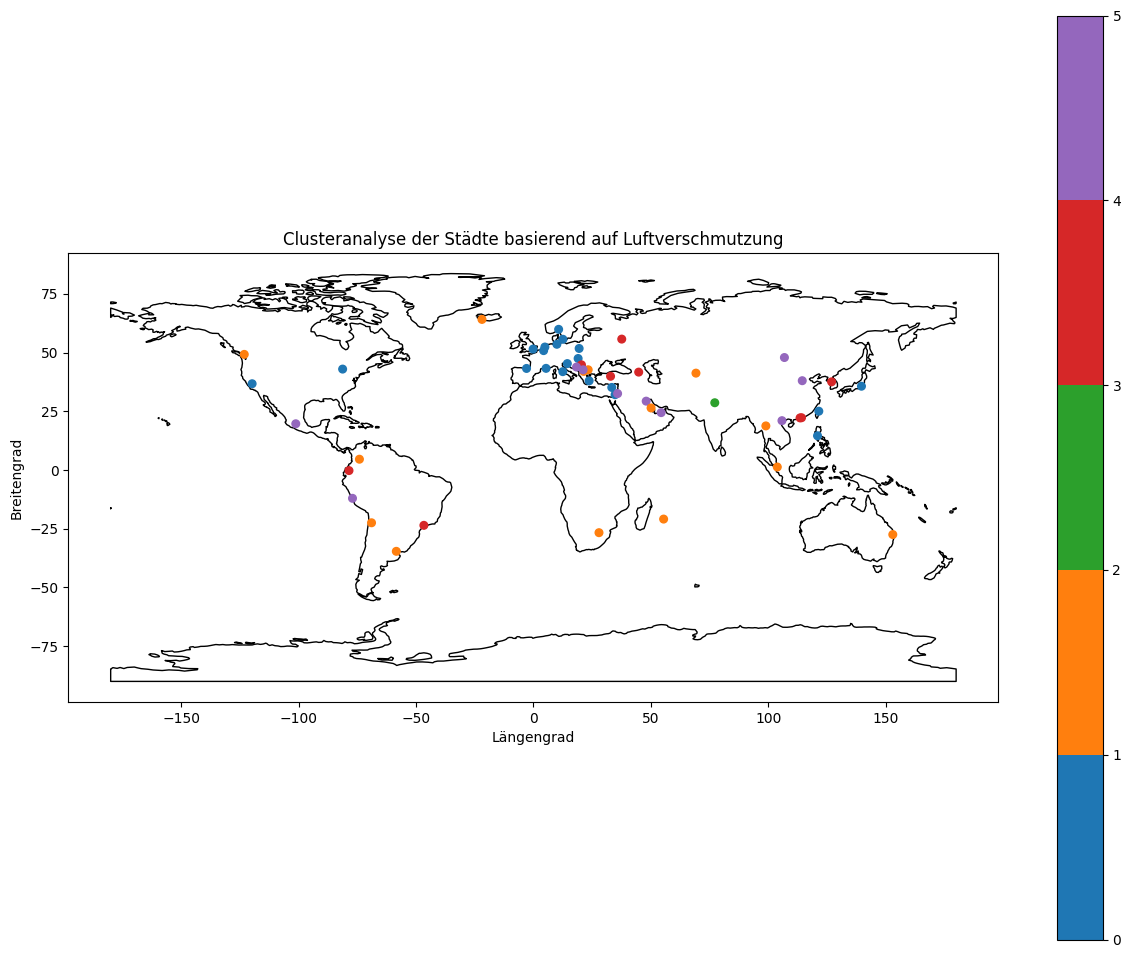

In [47]:
# Plot erstellen
fig, ax = plt.subplots(figsize=(15, 12))

# Umrisse der Weltkarte plotten
world.plot(ax=ax, color='white', edgecolor='black')

# Städte als farbige Punkte nach Cluster einfärben
scatter = gdf_cities.plot(column="Cluster", cmap=custom_cmap, ax=ax, markersize=30, legend=True, alpha=1.0)

# Titel & Achsen
plt.title("Clusteranalyse der Städte basierend auf Luftverschmutzung")
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")

plt.savefig("../Images/cluster_plot.png", dpi=300, bbox_inches="tight")

plt.show()



In [46]:
# plt.savefig("cluster_plot.png", dpi=300, bbox_inches="tight")
plt.savefig("../Images/cluster_plot.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>